# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle, os
from IPython.display import clear_output

In [2]:
from tqdm.auto import tqdm, trange
tqdm.pandas()

D:\Users\Ritvik\Anaconda3\envs\datascience\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
pd.options.display.max_colwidth = -1

from dsutils.ml import *

# Data

In [4]:
data1 = pd.read_csv('emails.csv')
data2 = pd.read_csv('sms.csv')
data3 = pd.read_csv('Youtube01-Psy.csv')
data4 = pd.read_csv('Youtube02-KatyPerry.csv')
data5 = pd.read_csv('Youtube03-LMFAO.csv')
data6 = pd.read_csv('Youtube04-Eminem.csv')
data7 = pd.read_csv('Youtube05-Shakira.csv')
data8 = pd.read_csv('spam_or_not_spam.csv')

In [5]:
data = pd.DataFrame(columns=['Text', 'Spam'])

for i in trange(len(data1)):
    data = pd.concat([data, pd.DataFrame({
        'Text': [data1['text'][i].replace('Subject: ', '')],
        'Spam': [data1['spam'][i]]
    })])

for i in trange(len(data2)):
    data = pd.concat([data, pd.DataFrame({
        'Text': [data2['message'][i]],
        'Spam': [int(data2['label'][i] == 'spam')]
    })])

for i in trange(len(data3)):
    data = pd.concat([data, pd.DataFrame({
        'Text': [data3['CONTENT'][i]],
        'Spam': [data3['CLASS'][i]]
    })])

for i in trange(len(data4)):
    data = pd.concat([data, pd.DataFrame({
        'Text': [data4['CONTENT'][i]],
        'Spam': [data4['CLASS'][i]]
    })])
    
for i in trange(len(data5)):
    data = pd.concat([data, pd.DataFrame({
        'Text': [data5['CONTENT'][i]],
        'Spam': [data5['CLASS'][i]]
    })])

for i in trange(len(data6)):
    data = pd.concat([data, pd.DataFrame({
        'Text': [data6['CONTENT'][i]],
        'Spam': [data6['CLASS'][i]]
    })])  

for i in trange(len(data7)):
    data = pd.concat([data, pd.DataFrame({
        'Text': [data7['CONTENT'][i]],
        'Spam': [data7['CLASS'][i]]
    })])
    
for i in trange(len(data8)):
    data = pd.concat([data, pd.DataFrame({
        'Text': [data8['email'][i]],
        'Spam': [data8['label'][i]]
    })])    
    
data.drop_duplicates(inplace=True)
    
print('Done')

print(len(data))


Done
15497


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier

from sklearn.pipeline import Pipeline

In [7]:
from pipeline_utils import *

# Pipeline

In [8]:
X= data['Text'].values
y=data['Spam'].astype('int').values

print('X shape', X.shape)
print('Y shape', y.shape)

X shape (15497,)
Y shape (15497,)


Mean Loss 0.8330643287032217 +- 0.0051505589732209235


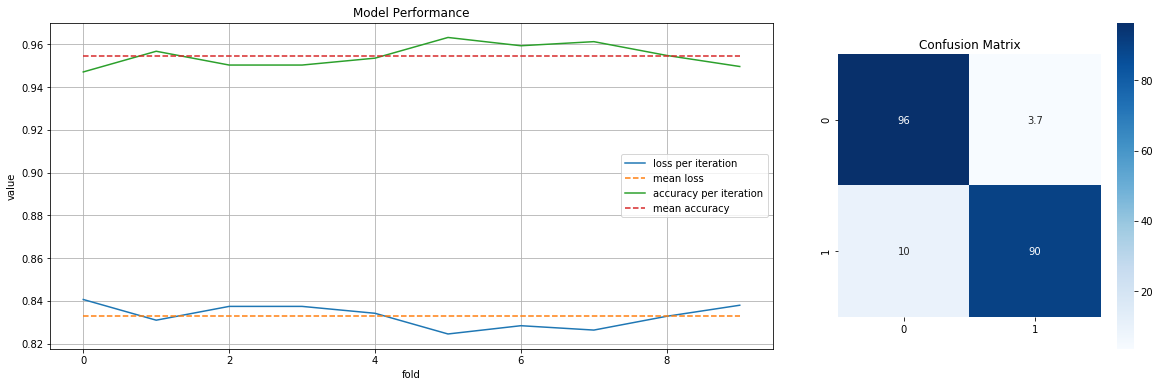

In [9]:
cleaner = TextCleaner()
vectorizer = TfidfVectorizer(smooth_idf=True)
featurer = NBFeaturer()
model = VotingClassifier(estimators=[
    ('SGD-H2', SGDClassifier(loss='hinge', max_iter=100000, tol=0.001, penalty='l2', random_state=101, warm_start=True, 
                             class_weight='balanced', early_stopping=True)),
    ('LR-2', LogisticRegression(solver='lbfgs', max_iter=100000, class_weight='balanced', random_state=101, warm_start=True)),
    ('SGD-H1', SGDClassifier(loss='hinge', max_iter=100000, tol=0.001, penalty='l1', random_state=101, warm_start=True, 
                             class_weight='balanced', early_stopping=True)),
    ('SGD-P2', SGDClassifier(loss='perceptron', max_iter=100000, tol=0.001, penalty='l2', random_state=101, warm_start=True,
                             class_weight='balanced', early_stopping=True)),
    ('SGD-L2', SGDClassifier(loss='log', max_iter=100000, tol=0.001, penalty='l2', random_state=101, warm_start=True, 
                             class_weight='balanced', early_stopping=True)),
    ('SGD-L1', SGDClassifier(loss='log', max_iter=100000, tol=0.001, penalty='l1', random_state=101, warm_start=True, 
                             class_weight='balanced', early_stopping=True)),
    ('LR-1', LogisticRegression(solver='liblinear', max_iter=100000, class_weight='balanced', random_state=101, 
                                warm_start=True))
    
])

p = Pipeline([
    ('clean', cleaner), 
    ('vectorize', vectorizer),
    ('featurize', featurer),
    ('model', model)
])

p_performance, p_cm, p_model = train_model_on_vects(p, X, y)
print('Mean Loss', np.mean(p_performance['loss']), '+-', np.std(p_performance['loss']))

In [10]:
pickle.dump(p_model, open('SpamFilterPipeline1.pkl', 'wb'))

# Over sampling

In [11]:
(len(data[data['Spam'] == 0])/len(data[data['Spam'] == 1]))

3.7103343465045593

In [12]:
data = pd.concat([
    data[data['Spam'] == 1],
    data[data['Spam'] == 1],
    data[data['Spam'] == 1],
    data[data['Spam'] == 1].sample(frac=0.71),
    data[data['Spam'] == 0]
]).sample(frac=1.00)

In [13]:
(len(data[data['Spam'] == 0])/len(data[data['Spam'] == 1]))

1.0000819269211862

In [17]:
X= data['Text'].values
y=data['Spam'].astype('int').values

print('X shape', X.shape)
print('Y shape', y.shape)

X shape (24413,)
Y shape (24413,)


Mean Loss 0.5408595053352979 +- 0.0034564160299295882


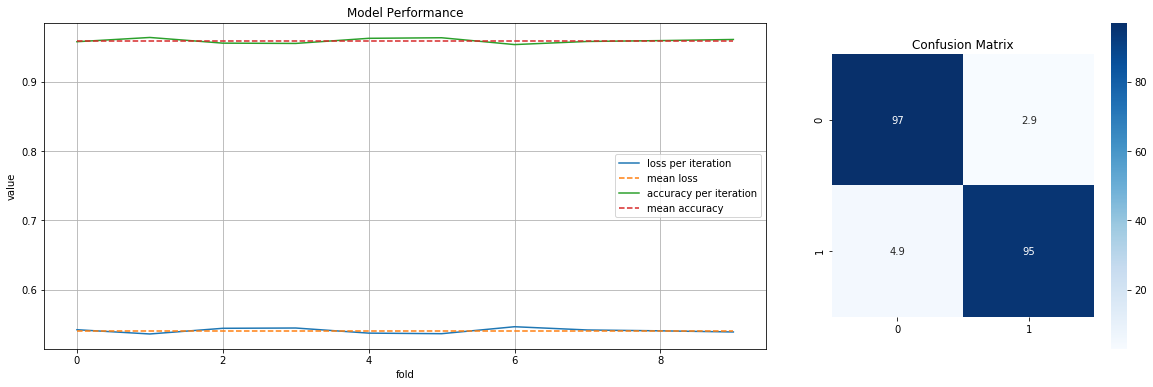

In [21]:
cleaner = TextCleaner()
vectorizer = TfidfVectorizer(smooth_idf=True)
model = VotingClassifier(estimators=[
    ('SGD-L1', SGDClassifier(loss='log', max_iter=100000, tol=0.001, penalty='l1', random_state=101, warm_start=True, 
                             class_weight='balanced', early_stopping=True)),
    ('SGD-L2', SGDClassifier(loss='log', max_iter=100000, tol=0.001, penalty='l2', random_state=101, warm_start=True, 
                             class_weight='balanced', early_stopping=True)),
    ('SGD-H1', SGDClassifier(loss='hinge', max_iter=100000, tol=0.001, penalty='l1', random_state=101, warm_start=True, 
                             class_weight='balanced', early_stopping=True)),
    ('SGD-H2', SGDClassifier(loss='hinge', max_iter=100000, tol=0.001, penalty='l2', random_state=101, warm_start=True, 
                             class_weight='balanced', early_stopping=True)),
    ('SGD-P2', SGDClassifier(loss='perceptron', max_iter=100000, tol=0.001, penalty='l2', random_state=101, warm_start=True,
                             class_weight='balanced', early_stopping=True)),
    ('LR-1', LogisticRegression(solver='liblinear', max_iter=100000, class_weight='balanced', random_state=101, 
                                warm_start=True)),
    ('LR-2', LogisticRegression(solver='lbfgs', max_iter=100000, class_weight='balanced', random_state=101, warm_start=True)),
    ('DT', DecisionTreeClassifier(random_state=101)),
], weights=[1, 1, 1, 36, 1, 1, 1, 1])

p = Pipeline([
    ('clean', cleaner), 
    ('vectorize', vectorizer),
    ('featurize', featurer),
    ('model', model)
])

p_performance, p_cm, p_model = train_model_on_vects(p, X, y)
print('Mean Loss', np.mean(p_performance['loss']), '+-', np.std(p_performance['loss']))

In [22]:
pickle.dump(p_model, open('SpamFilterPipeline2.pkl', 'wb'))